# 01 – Explore OPSD Germany Time Series

In this notebook I:
- Load hourly Germany load, solar, and wind data from Open Power System Data.
- Check basic data quality (ranges, missing values).
- Visualize the full time series and a sample month.
- Examine average daily profiles by hour of day.

This sets the context for the forecasting and probabilistic modeling in later notebooks.


## Load and inspect raw data

In [5]:
import sys, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Config
sns.set_context("talk")
sns.set_style("whitegrid")

# Paths and options
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
DATA_PATH = (PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv")
DATETIME_COL = "utc_timestamp"

In [6]:
import importlib
import src.data as data_mod
importlib.reload(data_mod)
from src.data import load_opsd_germany

# Load OPSD Germany subset with standardized columns ['load', 'solar', 'wind']
raw = load_opsd_germany(str(DATA_PATH))

# Sanity checks
assert raw.index.is_monotonic_increasing, "Index should be sorted by time"
assert raw.index.is_unique, "Expected unique timestamps"

expected_cols = {"load", "solar", "wind"}
missing_cols = expected_cols - set(raw.columns)
assert not missing_cols, f"Missing expected columns: {missing_cols}"

print(raw.index.min(), "->", raw.index.max(), "(n=", len(raw), ")")
raw.head()

2014-12-31 23:00:00+00:00 -> 2020-09-30 23:00:00+00:00 (n= 50401 )


,load,solar,wind
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,NaN,8852.0
2015-01-01 01:00:00+00:00,40135.0,NaN,9054.0
2015-01-01 02:00:00+00:00,39106.0,NaN,9070.0
2015-01-01 03:00:00+00:00,38765.0,NaN,9163.0


In [7]:
# Basic info
from IPython.display import display

raw.info()
display(raw.describe())
display(raw.isna().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    50400 non-null  float64
 1   solar   50297 non-null  float64
 2   wind    50326 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


,load,solar,wind
count,50400.000000,50297.000000,50326.000000
mean,55492.468552,4566.042905,11552.234650
std,10015.431042,6940.267590,9076.350769
min,31307.000000,0.000000,135.000000
25%,47106.000000,0.000000,4506.000000
50%,55092.000000,173.000000,9015.000000
75%,64309.250000,7342.000000,16113.750000
max,77549.000000,32947.000000,46064.000000


load       1
solar    104
wind      75
dtype: int64

## Missing data diagnostics

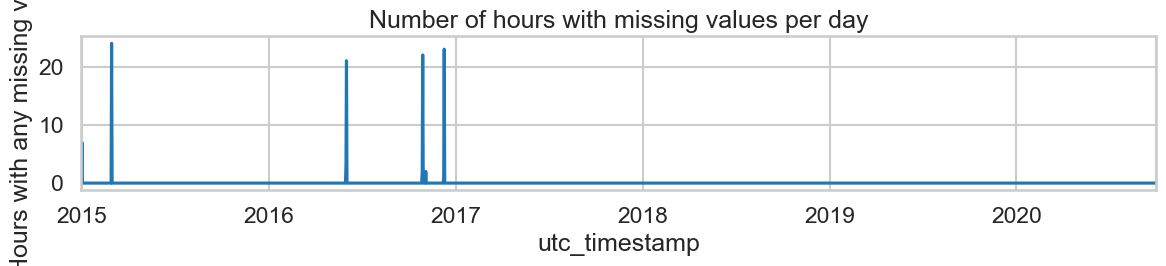

In [8]:
missing_per_day = (
    raw.isna().any(axis=1)
       .astype(int)
       .resample("D")
       .sum()
)

ax = missing_per_day.plot(kind="line", figsize=(12, 3))
ax.set_ylabel("Hours with any missing value")
plt.title("Number of hours with missing values per day")
plt.tight_layout()
plt.show()


## Long-term time-series plots

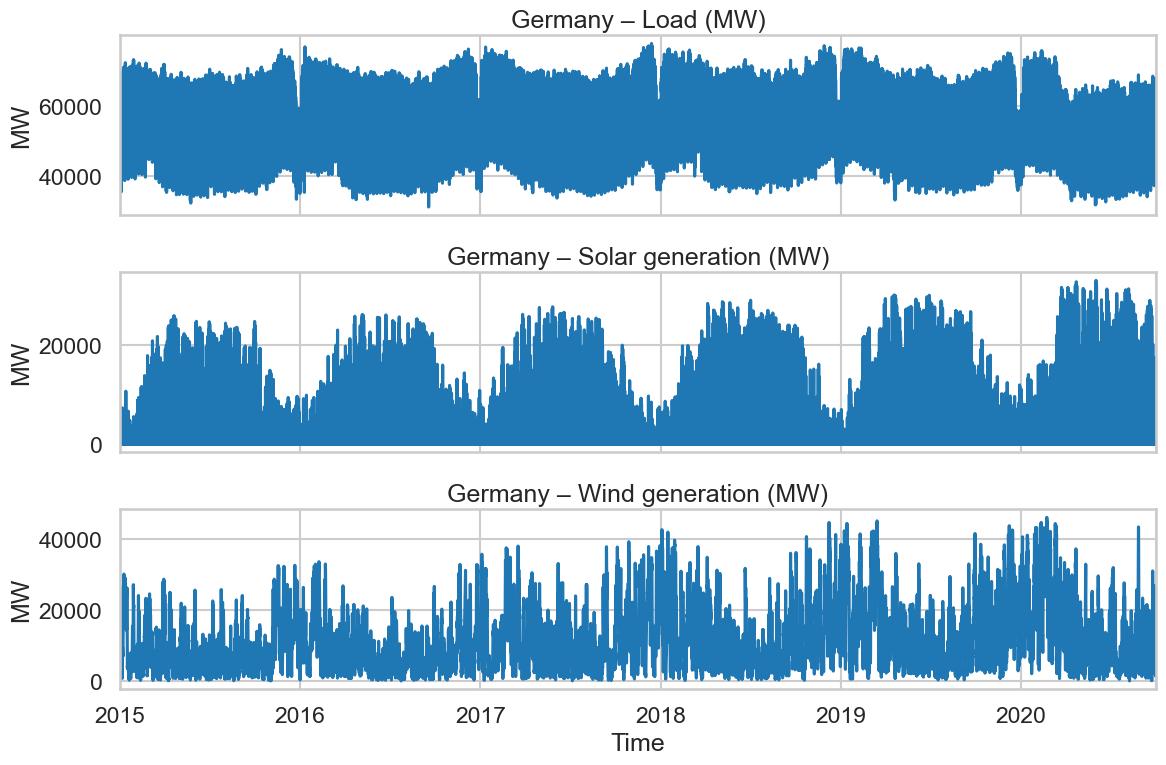

In [9]:
# Plot full time-series overview
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

raw["load"].plot(ax=axes[0])
axes[0].set_title("Germany – Load (MW)")
axes[0].set_ylabel("MW")

raw["solar"].plot(ax=axes[1])
axes[1].set_title("Germany – Solar generation (MW)")
axes[1].set_ylabel("MW")

raw["wind"].plot(ax=axes[2])
axes[2].set_title("Germany – Wind generation (MW)")
axes[2].set_ylabel("MW")

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()


System load stays mostly between ~35–75 GW with clear seasonal structure (higher in winter,
lower in summer) and a few visible drops that likely correspond to holidays or outages.
Solar generation shows a very strong annual cycle: near zero in winter months and large
midday peaks in summer, with an overall upward trend as installed capacity increases.
Wind generation is much more volatile day-to-day, with frequent spikes and lulls, and
appears to have stronger activity in some winters. Together these patterns motivate
including both seasonal and short-term temporal features in the forecasting models.

## Seasonal and daily patterns

/var/folders/zp/85klwk4938514ydsph5grv3m0000gq/T/ipykernel_22151/3911990017.py:4: UserWarning: Converting to Period representation will drop timezone information.
  last_month = last_ts.to_period("M")


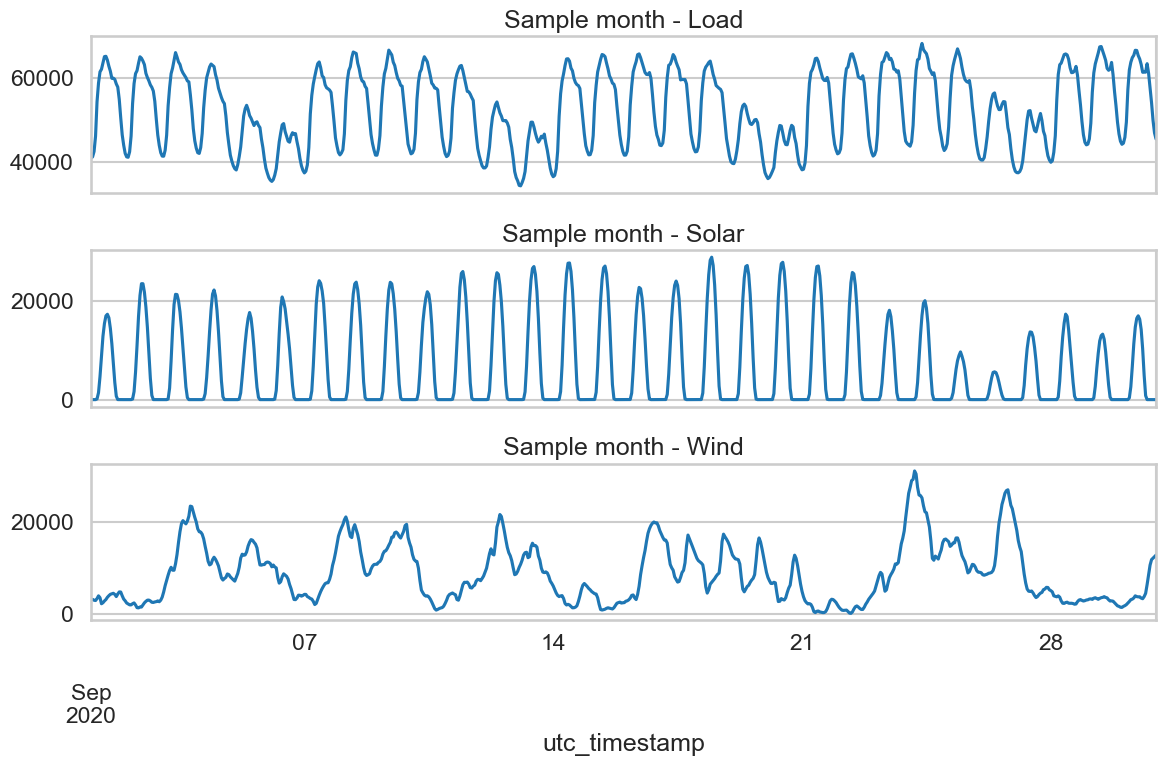

In [11]:
# Seasonal patterns: daily / weekly slice (sample month)
# Pick the last available month and align tz to avoid tz-naive/aware mismatch
last_ts = raw.index.max()
last_month = last_ts.to_period("M")
month_start = last_month.start_time
month_end = last_month.end_time

# Align timezone with the index if present
_tz = getattr(raw.index, "tz", None)
if _tz is not None:
    month_start = month_start.tz_localize(_tz)
    month_end = month_end.tz_localize(_tz)

sample = raw[month_start:month_end]

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
sample["load"].plot(ax=axes[0]); axes[0].set_title("Sample month - Load")
sample["solar"].plot(ax=axes[1]); axes[1].set_title("Sample month - Solar")
sample["wind"].plot(ax=axes[2]); axes[2].set_title("Sample month - Wind")
plt.tight_layout()
plt.show()


Over a single month, load exhibits a pronounced diurnal cycle: demand rises in the morning,
stays high during the day, and falls overnight, with some variation across weekdays and
weekends. Solar generation follows a clean bell-shaped daily pattern – zero at night and
peaking around midday – but the height of the peaks varies from day to day with weather.
Wind generation is less regular, with multi-day periods of high and low output that do not
align exactly with the solar cycle. This illustrates why short-term lags and daily/weekly
calendar effects are likely to be important predictors, while wind requires modeling
longer temporal dependence.


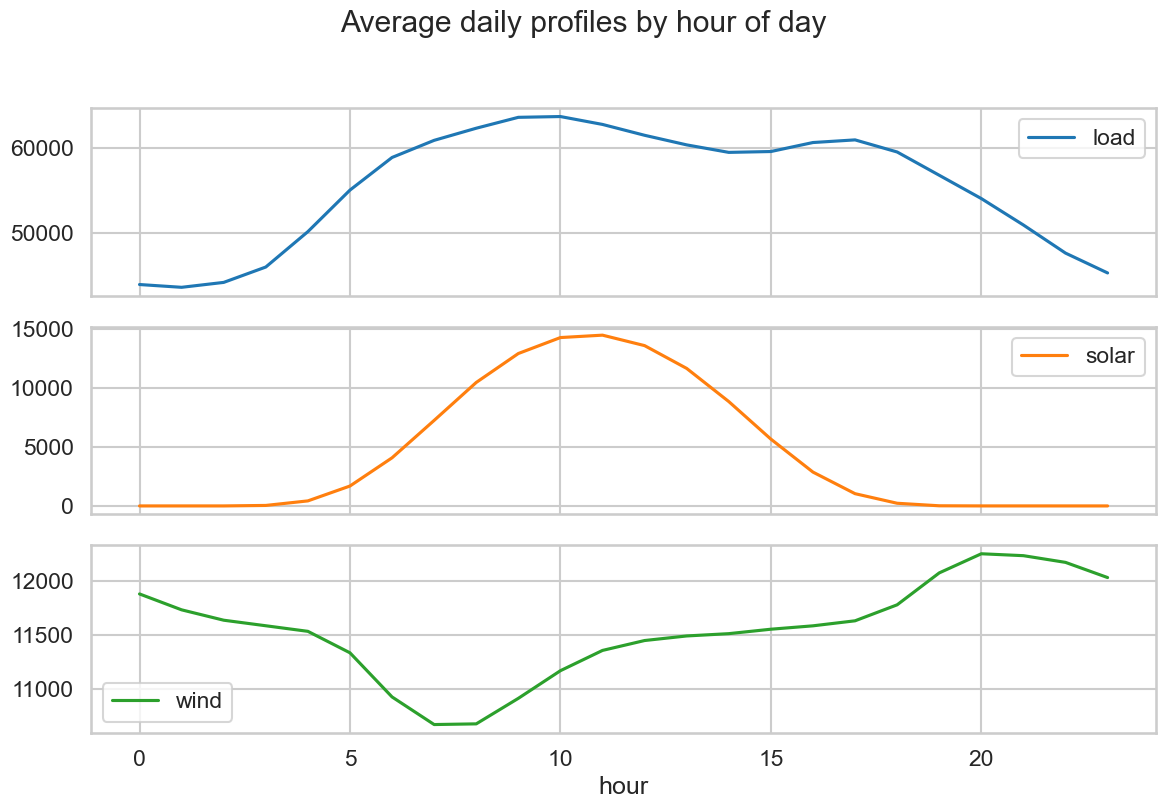

In [12]:
# Average daily profile
df_day = raw.copy()
df_day["hour"] = df_day.index.hour

daily_profile = df_day.groupby("hour")[ ["load", "solar", "wind"] ].mean()

axes = daily_profile.plot(subplots=True, layout=(3, 1), sharex=True, figsize=(12, 8))
plt.suptitle("Average daily profiles by hour of day", y=1.02)
plt.tight_layout()
plt.show()


On average, load is lowest in the early morning hours, ramps up sharply after ~6:00, and
reaches a broad plateau from late morning through early evening before declining at night.
Solar generation has the expected midday peak, with essentially zero output during nighttime
hours, confirming a strong alignment between solar availability and daytime demand.
Wind generation is comparatively flat over the day, with only a mild tendency toward higher
output in the late afternoon and evening. These average profiles justify using hour-of-day
features (e.g., sine/cosine encodings) and highlight the complementary shapes of load,
solar, and wind over a typical day.